# Investigating False Positives of the Graph-Manifold Adversarial Detector

This notebook stress-tests **false positives** for our current graph-manifold detector (threshold on a graph score such as `laplacian`).

We measure how often **benign** new samples are flagged as adversarial when we **add new samples to the point cloud**.

## What we test

- **IID new samples**: fresh two-moons samples from the same generator/noise.
- **Local jitter**: small Gaussian perturbations around clean test points.
- **Noise shift**: new two-moons samples with a different noise level.
- (Optional sanity) **Uniform OOD background**: random points in a bounding box (not false positives, but useful for context).

## Outputs

- False positive rate (FPR) per scenario
- Sensitivity to threshold percentile (90/95/97.5/99)
- A few plots showing score distributions + which new points get flagged



In [1]:
# Imports + path setup
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Ensure project root is on path
CWD = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CWD, "..")) if os.path.basename(CWD) == "notebooks" else os.path.abspath(CWD)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data import generate_two_moons, create_data_loaders
from src.models import TwoMoonsMLP, train_model, extract_features_batch, get_model_logits
from src.adv_attacks import generate_adversarial_examples
from src.detectors import ScoreBasedDetector
from src.utils import ExperimentConfig, set_seed

# Optional convenience
try:
    import pandas as pd
except Exception:
    pd = None

print(f"CWD: {CWD}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"src exists: {os.path.exists(os.path.join(PROJECT_ROOT, 'src'))}")



CWD: /Users/svenhockers/Desktop/Graph Manifold/notebooks
PROJECT_ROOT: /Users/svenhockers/Desktop/Graph Manifold
src exists: True


In [2]:
# Experiment configuration
BASE_SEEDS = [1, 2, 3, 4, 5]
THRESHOLD_PERCENTILES = [90, 95, 97.5, 99]

# Keep training fairly light (adjust if you want maximum accuracy)
BASE_CONFIG = ExperimentConfig(seed=42, device='cpu')
BASE_CONFIG.data.n_samples = 1000
BASE_CONFIG.data.noise = 0.1
BASE_CONFIG.model.epochs = 50
BASE_CONFIG.model.learning_rate = 1e-3
BASE_CONFIG.graph.k = 10
BASE_CONFIG.graph.space = 'feature'
BASE_CONFIG.attack.attack_type = 'fgsm'
BASE_CONFIG.attack.epsilon = 0.1

# How many new points to inject per scenario (per seed)
N_NEW = 1000

# Jitter strengths for benign local perturbations
JITTER_SIGMAS = [0.01, 0.03, 0.05]

# Noise shifts for generator
NOISE_SHIFTS = [0.05, 0.15, 0.25]



In [3]:
# Fast batched score computation (matches src.graph_manifold logic, but avoids per-point kNN refits)
import torch
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from typing import Optional, Dict


def _sigma_from_training(Z_train: np.ndarray) -> float:
    # Matches src.graph_manifold.compute_*_score when sigma=None
    # (it uses median of pairwise distances over the entire training set)
    return float(np.median(pdist(Z_train)))


def compute_graph_scores_fast(
    X_points: np.ndarray,
    model,
    Z_train: np.ndarray,
    f_train: np.ndarray,
    *,
    k: int,
    sigma: Optional[float],
    space: str,
    device: str = 'cpu',
) -> Dict[str, np.ndarray]:
    """Return {'degree': ..., 'laplacian': ...} for X_points."""
    if space == 'feature':
        Z_points = extract_features_batch(model, X_points, layer='penultimate', device=device)
    else:
        Z_points = X_points

    logits = get_model_logits(model, X_points, device=device)
    probs = torch.softmax(torch.as_tensor(logits, dtype=torch.float32), dim=1).cpu().numpy()
    f_points = probs[:, 1]

    if sigma is None:
        sigma = _sigma_from_training(Z_train)

    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(Z_train)
    distances, indices = nbrs.kneighbors(Z_points)

    weights = np.exp(-(distances ** 2) / (2 * (sigma ** 2)))

    degree_scores = -weights.sum(axis=1)
    laplacian_scores = np.sum(weights * (f_points[:, None] - f_train[indices]) ** 2, axis=1)

    return {'degree': degree_scores, 'laplacian': laplacian_scores}


# Quick correctness check vs the reference implementation on a tiny batch (optional)
from src.graph_manifold import compute_graph_scores as compute_graph_scores_ref

def sanity_check_scores(model, X_points, Z_train, f_train, config):
    X_small = X_points[:10]
    ref = compute_graph_scores_ref(X_small, model, Z_train, f_train, config.graph, device=config.device)
    fast = compute_graph_scores_fast(
        X_small, model, Z_train, f_train,
        k=config.graph.k, sigma=config.graph.sigma, space=config.graph.space, device=config.device
    )
    for key in ['degree', 'laplacian']:
        max_abs = float(np.max(np.abs(ref[key] - fast[key])))
        print(f"{key}: max |ref-fast| = {max_abs:.6e}")



In [ ]:
# Train model + build graph reference set + train detector threshold
from copy import deepcopy


from typing import Optional

def make_config(seed: int, *, noise: Optional[float] = None) -> ExperimentConfig:
    cfg = ExperimentConfig(seed=seed, device=BASE_CONFIG.device)
    # data
    cfg.data.n_samples = BASE_CONFIG.data.n_samples
    cfg.data.noise = BASE_CONFIG.data.noise if noise is None else float(noise)
    cfg.data.random_state = seed
    # model
    cfg.model.epochs = BASE_CONFIG.model.epochs
    cfg.model.learning_rate = BASE_CONFIG.model.learning_rate
    cfg.model.batch_size = BASE_CONFIG.model.batch_size
    # attack
    cfg.attack.attack_type = BASE_CONFIG.attack.attack_type
    cfg.attack.epsilon = BASE_CONFIG.attack.epsilon
    # graph
    cfg.graph.k = BASE_CONFIG.graph.k
    cfg.graph.sigma = BASE_CONFIG.graph.sigma
    cfg.graph.space = BASE_CONFIG.graph.space
    return cfg


def train_pipeline(seed: int, *, include_adv_test: bool = False):
    """Train classifier; compute Z_train, f_train; generate adv-val for detector training.

    Set include_adv_test=True when you want TP/FP/TN/FN confusion matrices (needs X_adv_test).
    """
    set_seed(seed)
    config = make_config(seed)

    X_train, y_train, X_val, y_val, X_test, y_test = generate_two_moons(
        n_samples=config.data.n_samples,
        noise=config.data.noise,
        random_state=config.data.random_state,
        train_ratio=config.data.train_ratio,
        val_ratio=config.data.val_ratio,
        test_ratio=config.data.test_ratio,
    )

    train_loader, val_loader, test_loader = create_data_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=config.model.batch_size
    )

    model = TwoMoonsMLP(
        input_dim=config.model.input_dim,
        hidden_dims=config.model.hidden_dims,
        output_dim=config.model.output_dim,
        activation=config.model.activation,
    )

    history = train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=False)

    # Training reference set (for kNN graph scoring)
    if config.graph.space == 'feature':
        Z_train = extract_features_batch(model, X_train, layer='penultimate', device=config.device)
    else:
        Z_train = X_train

    logits_train = get_model_logits(model, X_train, device=config.device)
    probs_train = torch.softmax(torch.as_tensor(logits_train, dtype=torch.float32), dim=1).cpu().numpy()
    f_train = probs_train[:, 1]

    # Adversarial examples (used only for detector training/eval; false positives are measured on benign injections)
    X_adv_val = generate_adversarial_examples(model, X_val, y_val, config.attack, device=config.device)

    X_adv_test = None
    scores_test_adv = None
    if include_adv_test:
        X_adv_test = generate_adversarial_examples(model, X_test, y_test, config.attack, device=config.device)
        scores_test_adv = compute_graph_scores_fast(
            X_adv_test, model, Z_train, f_train,
            k=config.graph.k, sigma=config.graph.sigma, space=config.graph.space, device=config.device
        )

    # Scores on validation set
    scores_val_clean = compute_graph_scores_fast(
        X_val, model, Z_train, f_train,
        k=config.graph.k, sigma=config.graph.sigma, space=config.graph.space, device=config.device
    )
    scores_val_adv = compute_graph_scores_fast(
        X_adv_val, model, Z_train, f_train,
        k=config.graph.k, sigma=config.graph.sigma, space=config.graph.space, device=config.device
    )

    # Also compute clean test scores for baseline FPR on held-out clean test set
    scores_test_clean = compute_graph_scores_fast(
        X_test, model, Z_train, f_train,
        k=config.graph.k, sigma=config.graph.sigma, space=config.graph.space, device=config.device
    )

    # (Optional) print a quick sanity check once per seed
    # sanity_check_scores(model, X_test, Z_train, f_train, config)

    bundle = {
        'seed': seed,
        'config': config,
        'model': model,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'Z_train': Z_train,
        'f_train': f_train,
        'scores_val_clean': scores_val_clean,
        'scores_val_adv': scores_val_adv,
        'scores_test_clean': scores_test_clean,
        'X_adv_test': X_adv_test,
        'scores_test_adv': scores_test_adv,
        'history': history,
    }
    return bundle


def fit_score_threshold_detector(scores_val_clean: dict, scores_val_adv: dict, *, score_type: str, percentile: float):
    # Combine scores to match the interface used elsewhere; threshold uses ONLY clean scores.
    scores_val_all = {k: np.concatenate([scores_val_clean[k], scores_val_adv[k]]) for k in scores_val_clean.keys()}
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[score_type]), dtype=int),
        np.ones(len(scores_val_adv[score_type]), dtype=int),
    ])

    det = ScoreBasedDetector(score_type=score_type)
    det.fit(scores_val_all, labels_val, percentile=percentile)
    return det



In [5]:
# Benign injection scenarios
from sklearn.datasets import make_moons


def generate_iid_new(n: int, *, noise: float, seed: int):
    X, y = make_moons(n_samples=n, noise=noise, random_state=seed)
    return X, y


def generate_local_jitter(X_base: np.ndarray, n: int, *, sigma: float, seed: int):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X_base), size=n, replace=True)
    X = X_base[idx] + rng.normal(loc=0.0, scale=sigma, size=(n, X_base.shape[1]))
    return X


def generate_uniform_ood(n: int, *, X_ref: np.ndarray, seed: int, margin: float = 0.5):
    rng = np.random.default_rng(seed)
    lo = X_ref.min(axis=0) - margin
    hi = X_ref.max(axis=0) + margin
    X = rng.uniform(low=lo, high=hi, size=(n, X_ref.shape[1]))
    return X


def score_and_flag(bundle, det: ScoreBasedDetector, X_points: np.ndarray, *, score_type: str = 'laplacian'):
    config = bundle['config']
    scores = compute_graph_scores_fast(
        X_points,
        bundle['model'],
        bundle['Z_train'],
        bundle['f_train'],
        k=config.graph.k,
        sigma=config.graph.sigma,
        space=config.graph.space,
        device=config.device,
    )
    preds = det.predict(scores)
    return scores, preds



In [6]:
# Run FP experiments
score_type = 'laplacian'

results = []

for seed in BASE_SEEDS:
    bundle = train_pipeline(seed)

    for percentile in THRESHOLD_PERCENTILES:
        det = fit_score_threshold_detector(
            bundle['scores_val_clean'], bundle['scores_val_adv'],
            score_type=score_type,
            percentile=float(percentile),
        )
        assert det.threshold is not None

        # Baseline: held-out clean test set
        preds_test = det.predict(bundle['scores_test_clean'])
        results.append({
            'seed': seed,
            'percentile': float(percentile),
            'scenario': 'clean_test',
            'n': int(len(preds_test)),
            'fp_rate': float(preds_test.mean()),
            'threshold': float(det.threshold),
        })

        # IID new samples
        X_iid, _ = generate_iid_new(N_NEW, noise=bundle['config'].data.noise, seed=seed + 1000)
        _, preds = score_and_flag(bundle, det, X_iid, score_type=score_type)
        results.append({
            'seed': seed,
            'percentile': float(percentile),
            'scenario': f'iid_new_noise={bundle["config"].data.noise}',
            'n': int(len(preds)),
            'fp_rate': float(preds.mean()),
            'threshold': float(det.threshold),
        })

        # Local jitter around clean test points
        for sigma in JITTER_SIGMAS:
            X_jit = generate_local_jitter(bundle['X_test'], N_NEW, sigma=float(sigma), seed=seed + 2000 + int(1000 * sigma))
            _, preds = score_and_flag(bundle, det, X_jit, score_type=score_type)
            results.append({
                'seed': seed,
                'percentile': float(percentile),
                'scenario': f'local_jitter_sigma={sigma}',
                'n': int(len(preds)),
                'fp_rate': float(preds.mean()),
                'threshold': float(det.threshold),
            })

        # Noise shift: still two-moons, but different noise levels
        for noise in NOISE_SHIFTS:
            X_shift, _ = generate_iid_new(N_NEW, noise=float(noise), seed=seed + 3000 + int(1000 * noise))
            _, preds = score_and_flag(bundle, det, X_shift, score_type=score_type)
            results.append({
                'seed': seed,
                'percentile': float(percentile),
                'scenario': f'noise_shift_noise={noise}',
                'n': int(len(preds)),
                'fp_rate': float(preds.mean()),
                'threshold': float(det.threshold),
            })

        # (Sanity) Uniform background points in a box around training data
        X_ood = generate_uniform_ood(N_NEW, X_ref=bundle['X_train'], seed=seed + 4000)
        _, preds = score_and_flag(bundle, det, X_ood, score_type=score_type)
        results.append({
            'seed': seed,
            'percentile': float(percentile),
            'scenario': 'uniform_ood_box',
            'n': int(len(preds)),
            'fp_rate': float(preds.mean()),
            'threshold': float(det.threshold),
        })

# Summarize
if pd is not None:
    df = pd.DataFrame(results)
    display(df.head())

    summary = (
        df.groupby(['scenario', 'percentile'])['fp_rate']
          .agg(['mean', 'std', 'count'])
          .reset_index()
          .sort_values(['scenario', 'percentile'])
    )
    display(summary)
else:
    # Minimal fallback summary
    from collections import defaultdict
    agg = defaultdict(list)
    for r in results:
        agg[(r['scenario'], r['percentile'])].append(r['fp_rate'])
    for (scenario, percentile), vals in sorted(agg.items()):
        vals = np.asarray(vals)
        print(f"{scenario:25s} p={percentile:5.1f}  mean={vals.mean():.4f}  std={vals.std():.4f}  n_seeds={len(vals)}")



clean_test                p= 90.0  mean=0.1020  std=0.0304  n_seeds=5
clean_test                p= 95.0  mean=0.0640  std=0.0198  n_seeds=5
clean_test                p= 97.5  mean=0.0290  std=0.0086  n_seeds=5
clean_test                p= 99.0  mean=0.0120  std=0.0024  n_seeds=5
iid_new_noise=0.1         p= 90.0  mean=0.0982  std=0.0145  n_seeds=5
iid_new_noise=0.1         p= 95.0  mean=0.0594  std=0.0162  n_seeds=5
iid_new_noise=0.1         p= 97.5  mean=0.0286  std=0.0091  n_seeds=5
iid_new_noise=0.1         p= 99.0  mean=0.0102  std=0.0031  n_seeds=5
local_jitter_sigma=0.01   p= 90.0  mean=0.1032  std=0.0350  n_seeds=5
local_jitter_sigma=0.01   p= 95.0  mean=0.0642  std=0.0175  n_seeds=5
local_jitter_sigma=0.01   p= 97.5  mean=0.0334  std=0.0106  n_seeds=5
local_jitter_sigma=0.01   p= 99.0  mean=0.0144  std=0.0048  n_seeds=5
local_jitter_sigma=0.03   p= 90.0  mean=0.1062  std=0.0257  n_seeds=5
local_jitter_sigma=0.03   p= 95.0  mean=0.0630  std=0.0181  n_seeds=5
local_jitter_sigma=0

In [7]:
# Plot FP rate vs threshold percentile (requires pandas)
if pd is not None:
    # Focus plots on benign-ish scenarios
    scenarios_to_plot = [
        'clean_test',
        f'iid_new_noise={BASE_CONFIG.data.noise}',
        *[f'local_jitter_sigma={s}' for s in JITTER_SIGMAS],
        *[f'noise_shift_noise={n}' for n in NOISE_SHIFTS],
        'uniform_ood_box',
    ]

    df_plot = df[df['scenario'].isin(scenarios_to_plot)].copy()

    fig, ax = plt.subplots(figsize=(12, 5))
    for scenario in scenarios_to_plot:
        sub = df_plot[df_plot['scenario'] == scenario]
        g = sub.groupby('percentile')['fp_rate'].mean().reset_index()
        ax.plot(g['percentile'], g['fp_rate'], marker='o', label=scenario)

    ax.set_xlabel('Threshold percentile (of clean validation scores)')
    ax.set_ylabel('Flag rate on injected points ("FP rate" for benign scenarios)')
    ax.set_title(f'False positive / flag rates vs threshold percentile (score_type={score_type})')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()



Example seed=1, percentile=95, scenario=IID new: flag-rate=0.0660
Threshold (laplacian) = 0.001437


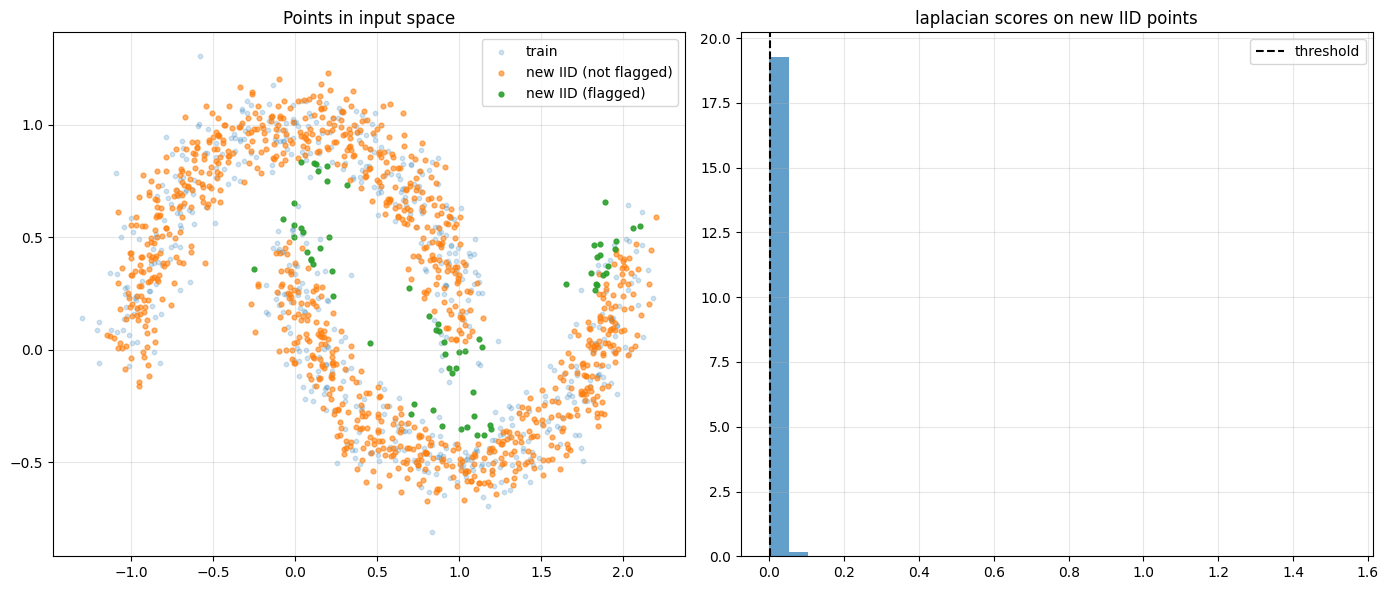

In [8]:
# Visualize which *new* points get flagged (single example run)
EXAMPLE_SEED = BASE_SEEDS[0]
EXAMPLE_PERCENTILE = 95

bundle = train_pipeline(EXAMPLE_SEED)
det = fit_score_threshold_detector(bundle['scores_val_clean'], bundle['scores_val_adv'], score_type=score_type, percentile=float(EXAMPLE_PERCENTILE))
assert det.threshold is not None

X_iid, y_iid = generate_iid_new(N_NEW, noise=bundle['config'].data.noise, seed=EXAMPLE_SEED + 1000)
scores_iid, preds_iid = score_and_flag(bundle, det, X_iid, score_type=score_type)

fp_rate = float(preds_iid.mean())
print(f"Example seed={EXAMPLE_SEED}, percentile={EXAMPLE_PERCENTILE}, scenario=IID new: flag-rate={fp_rate:.4f}")
print(f"Threshold ({score_type}) = {det.threshold:.6f}")

# Scatter: train set + new IID points, highlighting flagged
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(bundle['X_train'][:, 0], bundle['X_train'][:, 1], s=10, alpha=0.2, label='train')
axes[0].scatter(X_iid[~(preds_iid.astype(bool)), 0], X_iid[~(preds_iid.astype(bool)), 1], s=12, alpha=0.6, label='new IID (not flagged)')
axes[0].scatter(X_iid[(preds_iid.astype(bool)), 0], X_iid[(preds_iid.astype(bool)), 1], s=12, alpha=0.9, label='new IID (flagged)')
axes[0].set_title('Points in input space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Score distribution + threshold
axes[1].hist(scores_iid[score_type], bins=30, alpha=0.7, density=True)
axes[1].axvline(det.threshold, color='k', linestyle='--', label='threshold')
axes[1].set_title(f"{score_type} scores on new IID points")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



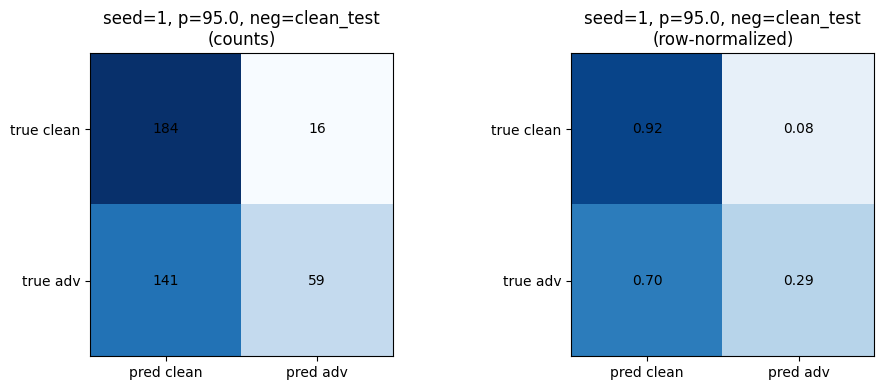

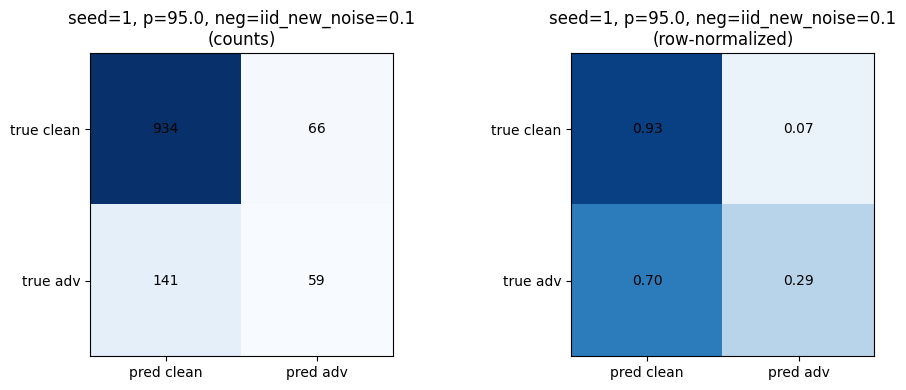

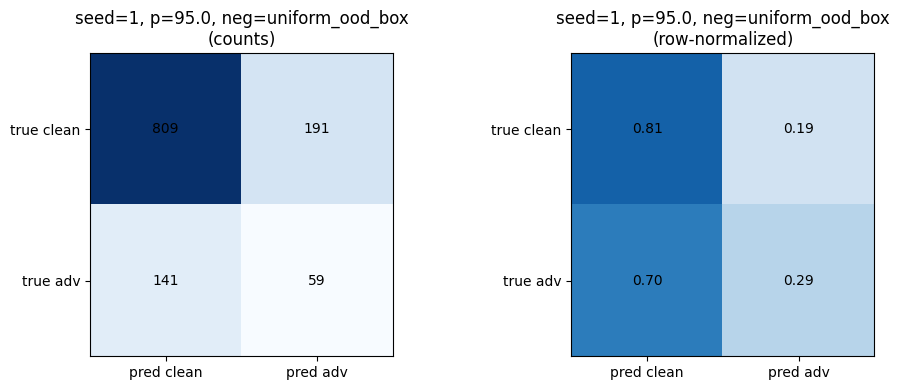

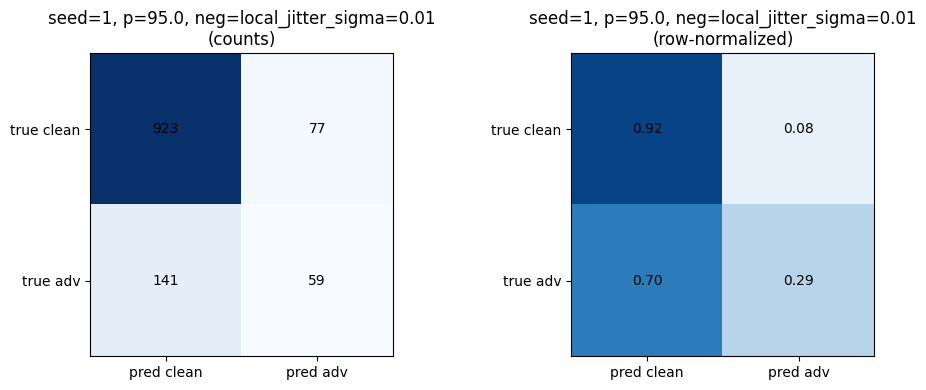

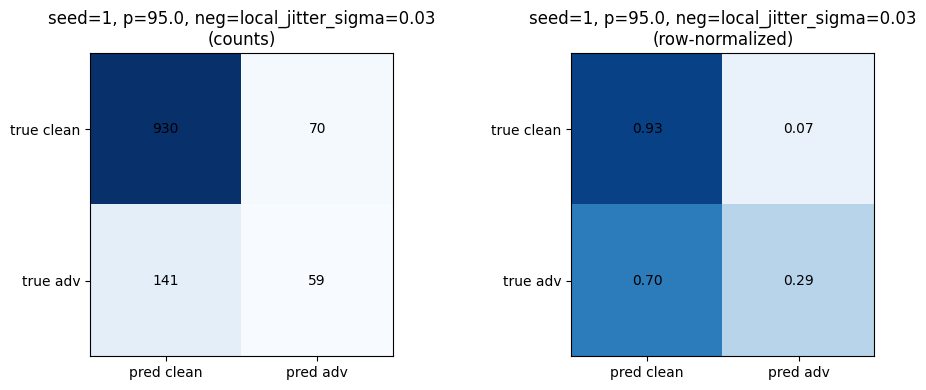

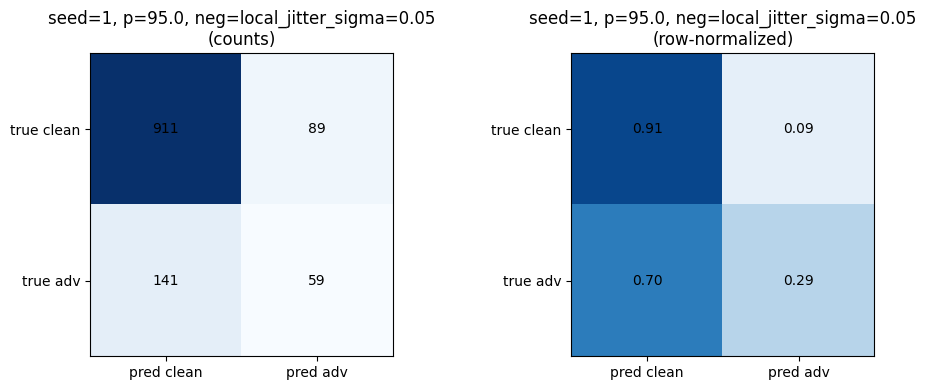

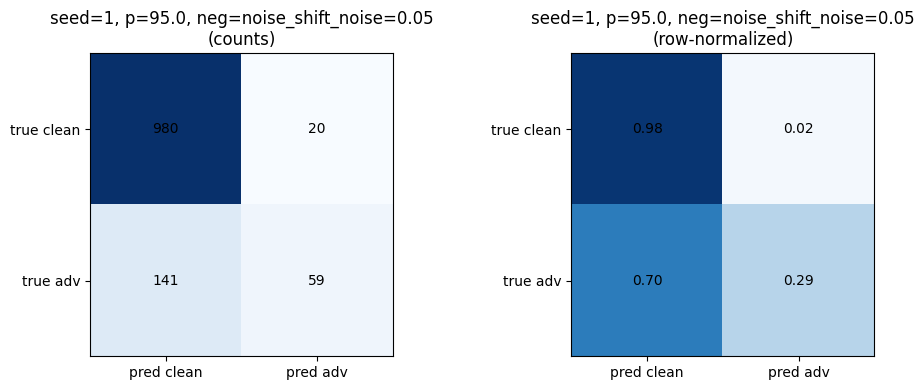

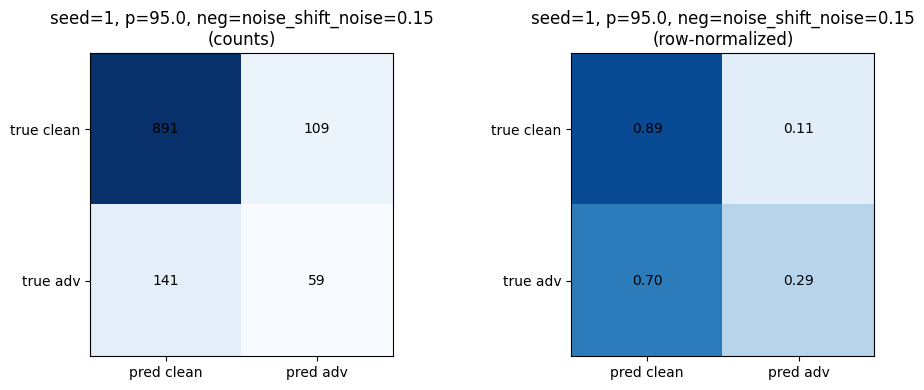

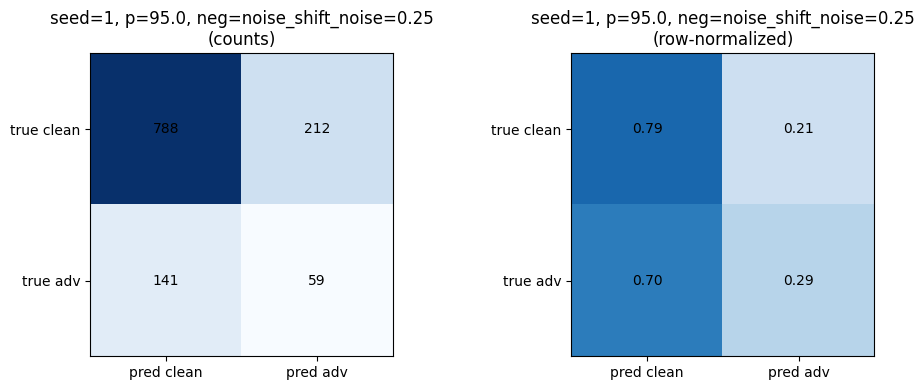

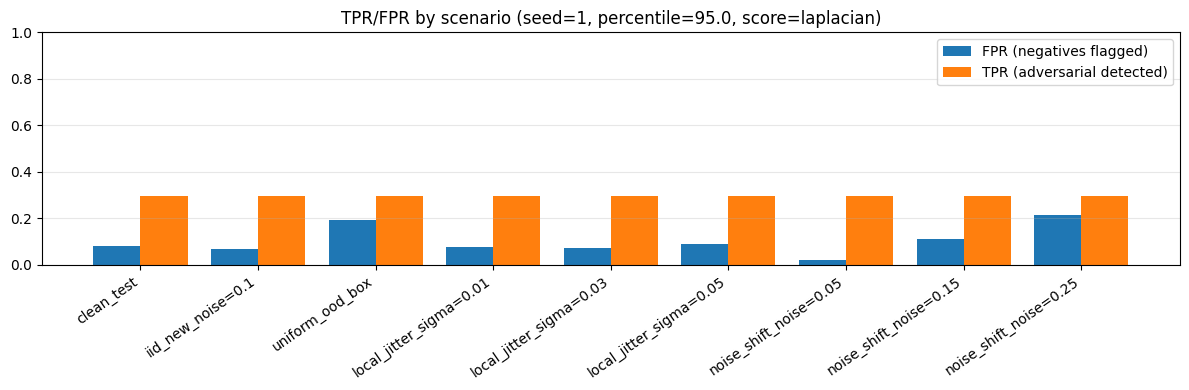

clean_test                 TPR=0.295  FPR=0.080  (TP=59 FP=16 TN=184 FN=141)
iid_new_noise=0.1          TPR=0.295  FPR=0.066  (TP=59 FP=66 TN=934 FN=141)
local_jitter_sigma=0.01    TPR=0.295  FPR=0.077  (TP=59 FP=77 TN=923 FN=141)
local_jitter_sigma=0.03    TPR=0.295  FPR=0.070  (TP=59 FP=70 TN=930 FN=141)
local_jitter_sigma=0.05    TPR=0.295  FPR=0.089  (TP=59 FP=89 TN=911 FN=141)
noise_shift_noise=0.05     TPR=0.295  FPR=0.020  (TP=59 FP=20 TN=980 FN=141)
noise_shift_noise=0.15     TPR=0.295  FPR=0.109  (TP=59 FP=109 TN=891 FN=141)
noise_shift_noise=0.25     TPR=0.295  FPR=0.212  (TP=59 FP=212 TN=788 FN=141)
uniform_ood_box            TPR=0.295  FPR=0.191  (TP=59 FP=191 TN=809 FN=141)


In [10]:
# Confusion matrices (TP / FP / TN / FN) for benign injections vs adversarial test positives

def confusion_counts(y_true: np.ndarray, y_pred: np.ndarray):
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return tp, fp, tn, fn


def rates_from_counts(tp: int, fp: int, tn: int, fn: int):
    tpr = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float('nan')
    return tpr, fpr


def plot_confusion(tp: int, fp: int, tn: int, fn: int, *, title: str):
    cm = np.array([[tn, fp], [fn, tp]], dtype=float)
    cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(cm, cmap='Blues')
    axes[0].set_title(title + "\n(counts)")
    axes[0].set_xticks([0, 1]); axes[0].set_yticks([0, 1])
    axes[0].set_xticklabels(['pred clean', 'pred adv'])
    axes[0].set_yticklabels(['true clean', 'true adv'])
    for (i, j), val in np.ndenumerate(cm):
        axes[0].text(j, i, f"{int(val)}", ha='center', va='center')

    axes[1].imshow(cm_norm, vmin=0, vmax=1, cmap='Blues')
    axes[1].set_title(title + "\n(row-normalized)")
    axes[1].set_xticks([0, 1]); axes[1].set_yticks([0, 1])
    axes[1].set_xticklabels(['pred clean', 'pred adv'])
    axes[1].set_yticklabels(['true clean', 'true adv'])
    for (i, j), val in np.ndenumerate(cm_norm):
        axes[1].text(j, i, f"{val:.2f}", ha='center', va='center')

    plt.tight_layout()
    plt.show()


CM_SEED = BASE_SEEDS[0]
CM_PERCENTILE = 95.0

# Backward-compatible: if you didn't re-run the cell that defines train_pipeline(include_adv_test=...),
# we still compute X_adv_test + scores here.
try:
    bundle_cm = train_pipeline(CM_SEED, include_adv_test=True)
except TypeError:
    bundle_cm = train_pipeline(CM_SEED)

# Ensure adversarial-test positives exist
if bundle_cm.get('X_adv_test') is None or bundle_cm.get('scores_test_adv') is None:
    X_adv_test = generate_adversarial_examples(
        bundle_cm['model'], bundle_cm['X_test'], bundle_cm['y_test'], bundle_cm['config'].attack, device=bundle_cm['config'].device
    )
    scores_test_adv = compute_graph_scores_fast(
        X_adv_test,
        bundle_cm['model'],
        bundle_cm['Z_train'],
        bundle_cm['f_train'],
        k=bundle_cm['config'].graph.k,
        sigma=bundle_cm['config'].graph.sigma,
        space=bundle_cm['config'].graph.space,
        device=bundle_cm['config'].device,
    )
    bundle_cm['X_adv_test'] = X_adv_test
    bundle_cm['scores_test_adv'] = scores_test_adv

# Detector threshold from val clean
cm_det = fit_score_threshold_detector(
    bundle_cm['scores_val_clean'], bundle_cm['scores_val_adv'],
    score_type=score_type,
    percentile=float(CM_PERCENTILE),
)
assert cm_det.threshold is not None

# Positives: adversarial test
y_pos = np.ones(len(bundle_cm['X_adv_test']), dtype=int)
p_pos = cm_det.predict(bundle_cm['scores_test_adv'])

# Define benign-negative scenarios
neg_scenarios = {
    'clean_test': bundle_cm['X_test'],
    f'iid_new_noise={bundle_cm["config"].data.noise}': generate_iid_new(N_NEW, noise=bundle_cm['config'].data.noise, seed=CM_SEED + 1000)[0],
    'uniform_ood_box': generate_uniform_ood(N_NEW, X_ref=bundle_cm['X_train'], seed=CM_SEED + 4000),
}
for s in JITTER_SIGMAS:
    neg_scenarios[f'local_jitter_sigma={s}'] = generate_local_jitter(bundle_cm['X_test'], N_NEW, sigma=float(s), seed=CM_SEED + 2000 + int(1000 * s))
for n in NOISE_SHIFTS:
    neg_scenarios[f'noise_shift_noise={n}'] = generate_iid_new(N_NEW, noise=float(n), seed=CM_SEED + 3000 + int(1000 * n))[0]

# Build and plot confusion matrices per negative scenario
rows = []
for scenario, X_neg in neg_scenarios.items():
    if scenario == 'clean_test':
        scores_neg = bundle_cm['scores_test_clean']
    else:
        scores_neg = compute_graph_scores_fast(
            X_neg,
            bundle_cm['model'],
            bundle_cm['Z_train'],
            bundle_cm['f_train'],
            k=bundle_cm['config'].graph.k,
            sigma=bundle_cm['config'].graph.sigma,
            space=bundle_cm['config'].graph.space,
            device=bundle_cm['config'].device,
        )
    y_neg = np.zeros(len(X_neg), dtype=int)
    p_neg = cm_det.predict(scores_neg)

    y_all = np.concatenate([y_neg, y_pos])
    p_all = np.concatenate([p_neg, p_pos])

    tp, fp, tn, fn = confusion_counts(y_all, p_all)
    tpr, fpr = rates_from_counts(tp, fp, tn, fn)

    rows.append({
        'scenario': scenario,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'TPR': tpr,
        'FPR': fpr,
        'threshold': float(cm_det.threshold),
        'percentile': float(CM_PERCENTILE),
        'seed': int(CM_SEED),
    })

    plot_confusion(tp, fp, tn, fn, title=f"seed={CM_SEED}, p={CM_PERCENTILE}, neg={scenario}")

# Summarize rates in a bar chart
labels = [r['scenario'] for r in rows]
fprs = [r['FPR'] for r in rows]
tprs = [r['TPR'] for r in rows]

fig, ax = plt.subplots(figsize=(12, 4))
x = np.arange(len(labels))
ax.bar(x - 0.2, fprs, width=0.4, label='FPR (negatives flagged)')
ax.bar(x + 0.2, tprs, width=0.4, label='TPR (adversarial detected)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=35, ha='right')
ax.set_ylim(0, 1)
ax.set_title(f"TPR/FPR by scenario (seed={CM_SEED}, percentile={CM_PERCENTILE}, score={score_type})")
ax.grid(True, axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

if pd is not None:
    display(pd.DataFrame(rows).sort_values('scenario'))
else:
    for r in sorted(rows, key=lambda d: d['scenario']):
        print(f"{r['scenario']:25s}  TPR={r['TPR']:.3f}  FPR={r['FPR']:.3f}  (TP={r['TP']} FP={r['FP']} TN={r['TN']} FN={r['FN']})")



In [13]:
# Visualize the local kNN graph neighborhood used to score/flag a point
from sklearn.neighbors import NearestNeighbors

try:
    from sklearn.decomposition import PCA
except Exception:
    PCA = None


def _get_Z_points(bundle, X_points: np.ndarray):
    cfg = bundle['config']
    if cfg.graph.space == 'feature':
        return extract_features_batch(bundle['model'], X_points, layer='penultimate', device=cfg.device)
    return X_points


def _get_f_points(bundle, X_points: np.ndarray) -> np.ndarray:
    logits = get_model_logits(bundle['model'], X_points, device=bundle['config'].device)
    probs = torch.softmax(torch.as_tensor(logits, dtype=torch.float32), dim=1).cpu().numpy()
    return probs[:, 1]


from typing import Optional

def visualize_point_graph_neighborhood(
    bundle,
    det: ScoreBasedDetector,
    x: np.ndarray,
    *,
    score_type: str = 'laplacian',
    k: Optional[int] = None,
    title: str = "",
    plot_space: str = 'input',  # 'input' or 'feature_pca'
    zoom: bool = True,
    zoom_margin: float = 0.35,
):
    """Visualize the kNN edges used to compute the score for one point x.

    Even if the scoring space is 'feature', we can still draw the neighborhood in input space for intuition.
    """
    cfg = bundle['config']
    if k is None:
        k = cfg.graph.k

    x = np.asarray(x).reshape(1, -1)

    Z_train = bundle['Z_train']
    f_train = bundle['f_train']

    z = _get_Z_points(bundle, x)
    f_z = float(_get_f_points(bundle, x)[0])

    if cfg.graph.sigma is None:
        sigma = _sigma_from_training(Z_train)
    else:
        sigma = float(cfg.graph.sigma)

    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(Z_train)
    distances, indices = nbrs.kneighbors(z)
    distances = distances[0]
    indices = indices[0]

    weights = np.exp(-(distances ** 2) / (2 * (sigma ** 2)))
    degree_score = float(-weights.sum())
    lap_contrib = weights * (f_z - f_train[indices]) ** 2
    lap_score = float(lap_contrib.sum())

    score_val = lap_score if score_type == 'laplacian' else degree_score
    thr = det.threshold
    flagged = (thr is not None) and (score_val > float(thr))

    # Choose coordinates to plot
    if plot_space == 'feature_pca' and PCA is not None:
        Z_all = np.vstack([Z_train, z])
        pca = PCA(n_components=2, random_state=0)
        Z2 = pca.fit_transform(Z_all)
        coords_train = Z2[:-1]
        coord_x = Z2[-1]
        coords_neigh = coords_train[indices]
        xlabel = 'PCA-1 (feature)'
        ylabel = 'PCA-2 (feature)'
    else:
        coords_train = bundle['X_train']
        coord_x = x[0]
        coords_neigh = coords_train[indices]
        xlabel = 'x1'
        ylabel = 'x2'

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    ax.scatter(coords_train[:, 0], coords_train[:, 1], s=8, alpha=0.15, label='train')
    ax.scatter(coords_neigh[:, 0], coords_neigh[:, 1], s=40, alpha=0.9, label='neighbors')
    ax.scatter([coord_x[0]], [coord_x[1]], s=80, c='red', marker='x', label='query x')

    # Draw edges from query to neighbors (thickness ~ weight)
    w_max = float(np.max(weights)) if len(weights) else 1.0
    for (pt, w) in zip(coords_neigh, weights):
        lw = 0.5 + 3.5 * (float(w) / (w_max + 1e-12))
        ax.plot([coord_x[0], pt[0]], [coord_x[1], pt[1]], color='black', alpha=0.35, linewidth=lw)

    # Zoom/crop around the neighborhood (query + neighbors)
    if zoom:
        pts = np.vstack([coords_neigh, np.asarray(coord_x).reshape(1, -1)])
        x_min, y_min = pts.min(axis=0)
        x_max, y_max = pts.max(axis=0)
        dx = float(x_max - x_min)
        dy = float(y_max - y_min)
        # Handle degenerate ranges
        if dx < 1e-9:
            dx = 1.0
        if dy < 1e-9:
            dy = 1.0
        pad_x = zoom_margin * dx
        pad_y = zoom_margin * dy
        ax.set_xlim(float(x_min - pad_x), float(x_max + pad_x))
        ax.set_ylim(float(y_min - pad_y), float(y_max + pad_y))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)

    flag_txt = 'FLAGGED' if flagged else 'not flagged'
    ax.set_title((title + "\n" if title else "") + f"Local kNN neighborhood ({plot_space}); {flag_txt}")
    ax.legend(loc='best')

    ax2 = axes[1]
    order = np.argsort(lap_contrib)[::-1]
    ax2.bar(np.arange(len(order)), lap_contrib[order])
    ax2.set_xlabel('Neighbor rank (by contribution)')
    ax2.set_ylabel('Contribution to Laplacian score')
    ax2.set_title(
        f"Scores: lap={lap_score:.6f}, degree={degree_score:.6f}\n"
        f"threshold({score_type})={float(thr) if thr is not None else None}"
    )
    ax2.grid(True, axis='y', alpha=0.25)

    plt.tight_layout()
    plt.show()

    return {
        'indices': indices,
        'distances': distances,
        'weights': weights,
        'laplacian_contrib': lap_contrib,
        'laplacian_score': lap_score,
        'degree_score': degree_score,
        'flagged': flagged,
        'threshold': thr,
        'f_z': f_z,
    }



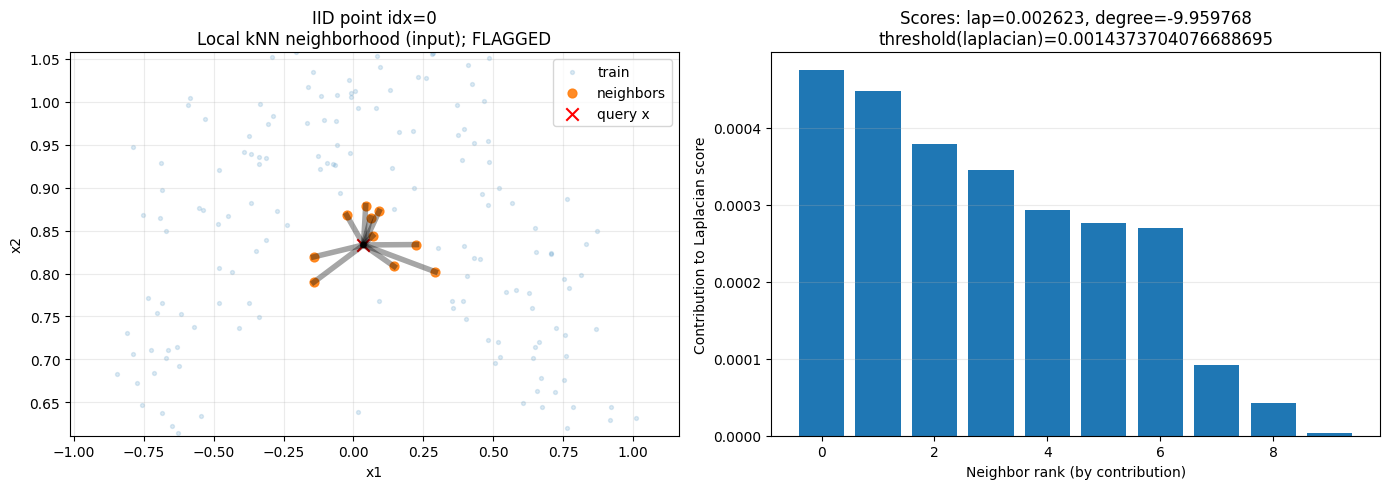

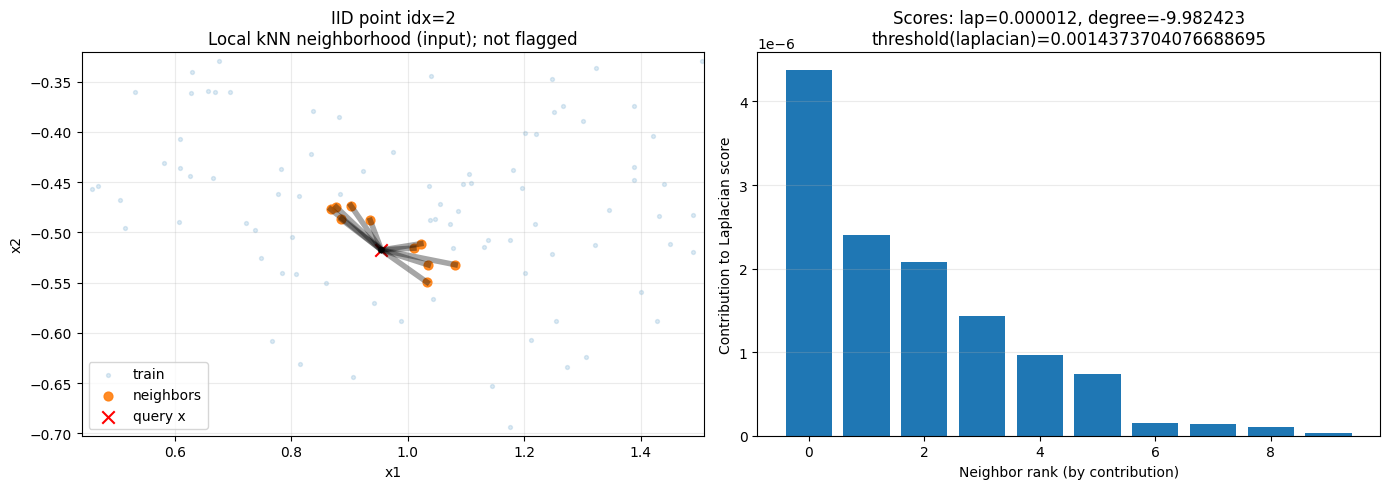

In [20]:
# Example: visualize one flagged vs one not-flagged point (IID injection)
# Requires you to have run the earlier cell that defines: bundle, det, X_iid, preds_iid

try:
    _bundle = bundle
    _det = det
    _X_iid = X_iid
    _preds = preds_iid
except NameError:
    # Fallback: reproduce a single example run
    EXAMPLE_SEED = BASE_SEEDS[0]
    EXAMPLE_PERCENTILE = 95.0
    _bundle = train_pipeline(EXAMPLE_SEED)
    _det = fit_score_threshold_detector(_bundle['scores_val_clean'], _bundle['scores_val_adv'], score_type=score_type, percentile=float(EXAMPLE_PERCENTILE))
    X_iid, _ = generate_iid_new(N_NEW, noise=_bundle['config'].data.noise, seed=EXAMPLE_SEED + 1000)
    _, _preds = score_and_flag(_bundle, _det, X_iid, score_type=score_type)
    _X_iid = X_iid

flagged_idx = np.where(_preds == 1)[0]
not_flagged_idx = np.where(_preds == 0)[0]

if len(flagged_idx) == 0:
    print("No flagged IID points found in this run; try a lower percentile (e.g. 90) or increase N_NEW.")
else:
    i_flag = int(flagged_idx[0])
    i_ok = int(not_flagged_idx[0])

    visualize_point_graph_neighborhood(
        _bundle, _det, _X_iid[i_flag],
        score_type=score_type,
        title=f"IID point idx={i_flag}",
        plot_space='input',
        zoom=True,
        zoom_margin=2,
    )

    visualize_point_graph_neighborhood(
        _bundle, _det, _X_iid[i_ok],
        score_type=score_type,
        title=f"IID point idx={i_ok}",
        plot_space='input',
        zoom=True,
        zoom_margin=2,
    )

    # Optional: if you want to see the neighborhood in the *feature* space (PCA projection)
    # visualize_point_graph_neighborhood(_bundle, _det, _X_iid[i_flag], score_type=score_type, title=f"IID idx={i_flag}", plot_space='feature_pca')

